# Chapter 4 - Training Models

In [38]:
import pandas as pd
import numpy as np

In [39]:
import os, itertools

In [40]:
from sklearn import datasets

In this chapter, we will start by looking at the **Linear Regression** model:

We will discuss two very different ways to train it:
* Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).

* Using an iterative optimization approach, called **Gradient Descent (GD)**, that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent that we will use again and again when we study neural networks in Part II: Batch GD, Mini-batch GD, and Stochastic GD.

Next we will look at **Polynomial Regression**, a more complex model that can fit nonlinear datasets. Since this model has more parameters than Linear Regression, it is more prone to overfitting the training data, so we will look at how to detect whether or not this is the case, using learning curves, and then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will look at two more models that are commonly used for classification tasks: **Logistic Regression** and **Softmax Regression**.

### Linear Regression

In Chapter 1, we looked at a simple regression model of life satisfaction: 

life_satisfaction = $\theta_0$ + $\theta_1$ × GDP_per_capita.

This model is just a linear function of the input feature GDP_per_capita. $\theta_0$ and $\theta_1$ are the model’s parameters.

More generally, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the **bias** term (also called the **intercept** term).

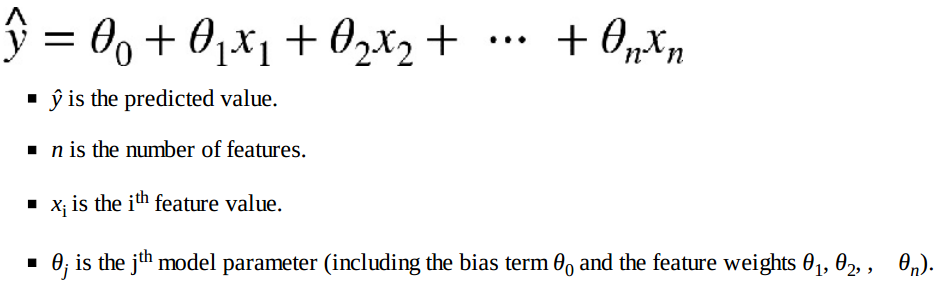

This can be written much more concisely using a vectorized form:

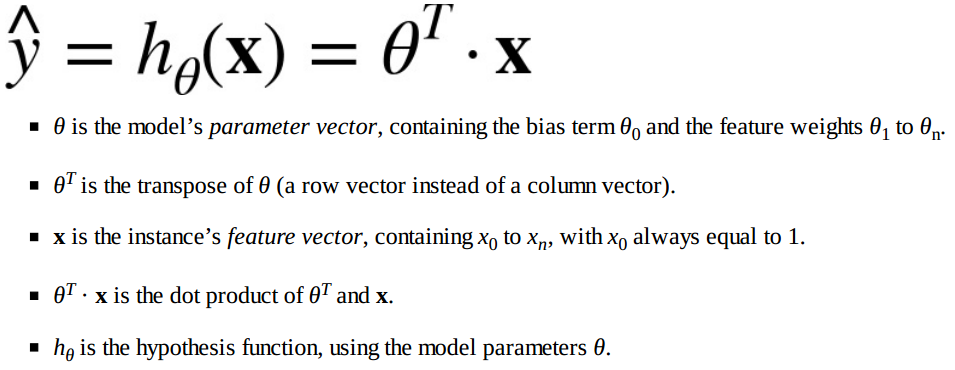

How do we train it? 

Training a model means setting its parameters so that the model best fits the training set. 

We first need a measure of how well (or poorly) the model fits the training data. 

We saw that the most common performance measure of a regression model is the Root Mean Square Error. 

Therefore, to train a Linear Regression model, you need to find the value of $\theta$ that minimizes the **RMSE**. 

In practice, it is simpler to minimize the **Mean Square Error (MSE)** than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root).

The MSE of a Linear Regression hypothesis $h_{\theta}$ on a training set $X$ is calculated using:

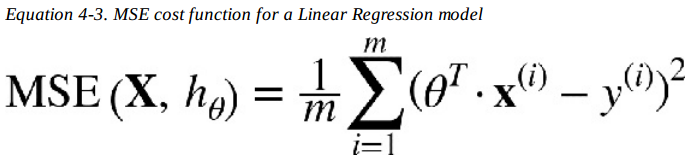

To simplify notations, we will just write $MSE{(θ)}$ instead of $MSE{(X, h_{\theta})}$.

### The Normal Equation

To find the value of $\theta$ that minimizes the cost function, there is a **closed-form** solution — in other words, a mathematical equation that gives the result directly. This is called the **Normal Equation**:

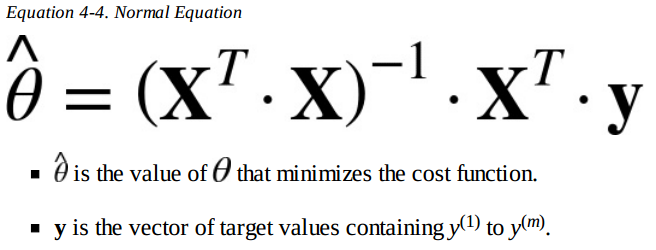

Let’s generate some linear-looking data to test this equation on:

In [41]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [42]:
import matplotlib.pylab as plt

In [43]:
%matplotlib inline

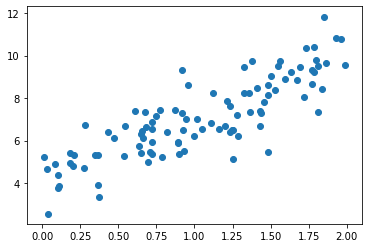

In [44]:
plt.scatter(X, y)

Let’s compute using the Normal Equation. We will use the `inv()` function from NumPy’s Linear
Algebra module (`np.linalg`) to compute the inverse of a matrix, and the `dot()` method for matrix multiplication:

In [45]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The actual function that we used to generate the data is $y = 4 + 3x_0 + Gaussian\; noise$. Let’s see what the
equation found:

In [46]:
theta_best

array([[4.15422276],
       [2.82123065]])

We would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$ instead of $\theta_0 = 4.215$ and $\theta_1 = 2.770$

Now you can make predictions using $\hat\theta$

In [47]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.15422276],
       [9.79668406]])

Let’s plot this model’s predictions

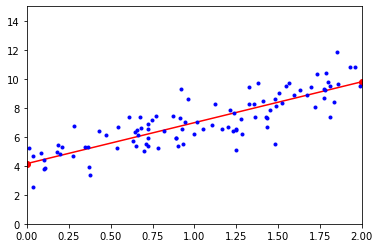

In [48]:
plt.scatter(X_new, y_predict, color="red")
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The equivalent code using Scikit-Learn looks like this:

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.15422276]), array([[2.82123065]]))

In [50]:
lin_reg.predict(X_new)

array([[4.15422276],
       [9.79668406]])

#### Computational Complexity

The Normal Equation computes the inverse of $X^T · X$, which is an $n × n$ matrix (where $n$ is **the number of features**). 

The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$ (depending on the implementation). 

In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4}$ = 5.3 to $2^3$ = 8.

**WARNING**:

The Normal Equation gets very slow when the number of features grows large (e.g., 100,000).

On the positive side, this equation is **linear** with regards to the **number of instances in the training set** (it is $O(m)$), so it handles large training sets efficiently, provided they can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), **predictions** are very fast: the computational complexity is **linear** with regards to both **the number of instances** you want to make predictions on and the **number of features**. 

In other words, making predictions on twice as many instances (or twice as many features) will just take roughly twice as much time.

Look at very different ways to train a Linear Regression model, better suited for cases **where there are a large number of features**, or **too many training instances to fit in memory**.

## Gradient Descent

Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. 

The general idea of Gradient Descent is to *tweak parameters iteratively in order to minimize a cost function*.

Suppose you are lost in the mountains in a dense fog; you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of *the steepest slope*. This is exactly what Gradient Descent does: 

it measures the local gradient of the error function with regards to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling $\theta$ with random values (this is called **random initialization**), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

An important parameter in Gradient Descent is **the size of the steps**, determined by the **learning rate** hyperparameter. 

If the learning rate is **too small**, then the algorithm will have to go through many iterations
to converge, which will take a long time.

On the other hand, if the learning rate is **too high**, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution. 

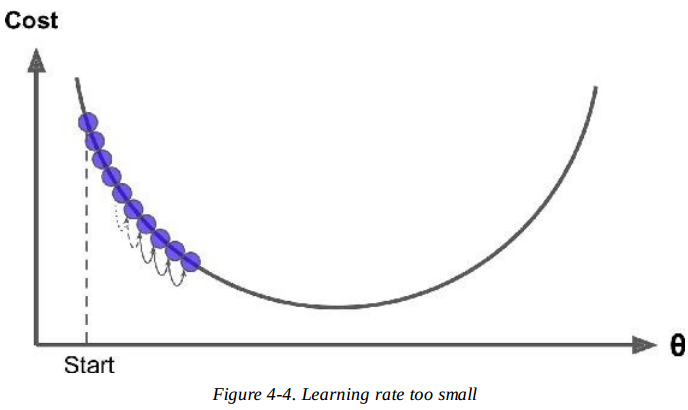

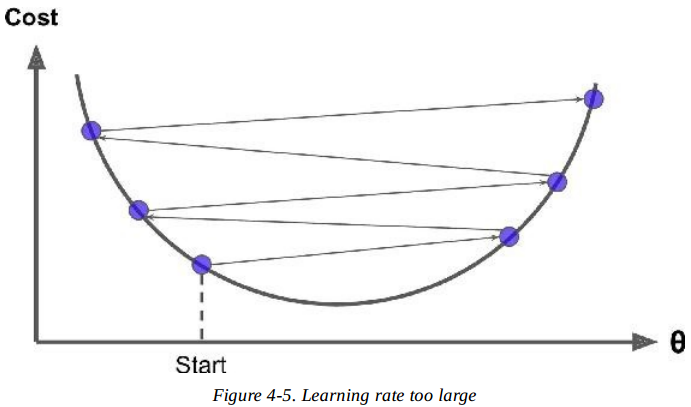

Finally, not all cost functions look like nice regular bowls. 
There may be *holes, ridges, plateaus, and all sorts of irregular terrains*, making convergence to the minimum very difficult. 

Figure 4-6 shows the two main challenges with Gradient Descent: 

if the random initialization starts the algorithm on the left, then it will converge to a **local minimum**, which is not as good as the global minimum. 

If it starts on the right, then it will take a very long time to cross the plateau, and if you stop too early you will never reach the global minimum.

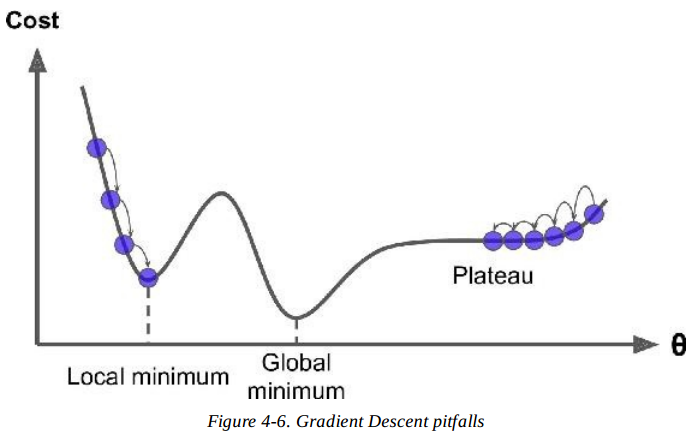

Fortunately, the MSE cost function for a Linear Regression model happens to be a **convex function**, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve.

This implies that there are no local minima, just one global minimum. It is also a continuous function with
a slope that never changes abruptly.

These two facts have a great consequence: 
**Gradient Descent is guaranteed to approach arbitrarily close the global minimum (if you wait long enough and if the learning rate is not too high).**

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. 

Figure 4-7 shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on
the right).

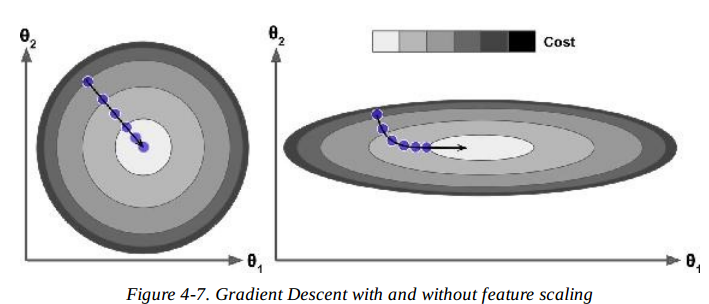

On the left the Gradient Descent algorithm goes straight toward the minimum, thereby reaching it quickly

On the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the
minimum, but it will take a long time.

**WARNING**
When using Gradient Descent, you should ensure that all features *have a similar scale* (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.

This diagram also illustrates the fact that training a model means searching for a combination of model
**parameters** that minimizes a cost function (over the training set). 

It is a search in the model’s **parameter space**: the more parameters a model has, the more dimensions this space has, and the harder the search is:
searching for a needle in a 300-dimensional haystack is much trickier than in three dimensions.
Fortunately, since the cost function is convex in the case of Linear Regression, the needle is simply at the bottom of the bowl.

### Batch Gradient Descent

To implement Gradient Descent, you need to compute the **gradient of the cost function with regards to each model parameter $\theta_j$**. 

In other words, you need to calculate how much the cost function will change if you change $\theta_j$ just a little bit. 
This is called a **partial derivative**. 

Equation 4-5 computes the partial derivative of the cost function with regards to parameter $\theta_j$:

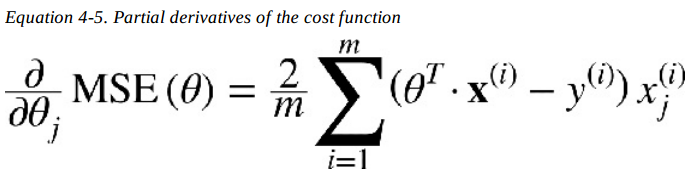

InsteYou can use Equation 4-6 to compute them **all in one go**. The gradient vector, contains all the partial derivatives of the cost function (one for each model parameter):

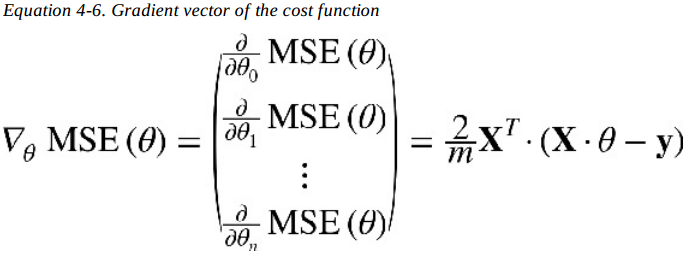

This formula involves calculations over the **full training set X**, at each Gradient Descent step! 
This is why the algorithm is called **Batch Gradient Descent**: it uses the whole batch of training data at every step. As a result **it is terribly slow on very large training sets**(but we will see much faster Gradient Descent algorithms shortly). 

However, **Gradient Descent scales well with the number of features**; training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation.

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill.

This means subtracting θMSE(θ) from θ. This is where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the size of the downhill step 

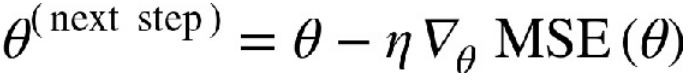

Let’s look at a quick implementation of this algorithm:

In [51]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1)  # random initialization
for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [52]:
theta

array([[4.15422276],
       [2.82123065]])

That’s exactly what the Normal Equation found! 

What if you had used a different learning rate eta? 

Figure 4-8 shows the first 10 steps of Gradient Descent using three different learning rates (the dashed line represents the starting point).

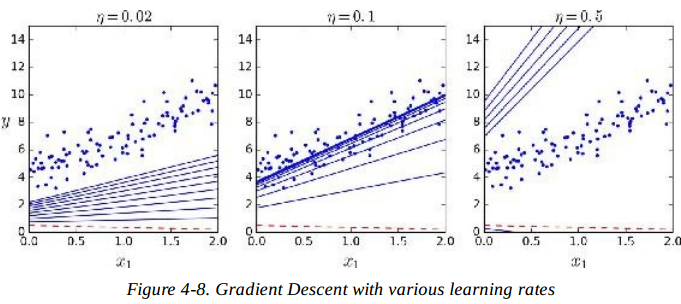

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. 

In the middle, the learning rate looks pretty good: in just a few iterations, it has already
converged to the solution. 

On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

To find a good learning rate, you can use *grid search*. 

You may want to limit the number of iterations so that grid search can eliminate models that take too long to converge.

You may wonder how to set the number of iterations. If it is too low, you will still be far away from the optimal solution when the algorithm stops, but if it is too high, you will waste time while the model parameters do not change anymore. 

A simple solution is to **set a very large number of iterations** but to interrupt the algorithm when the **gradient vector becomes tiny** — that is, when **its norm becomes smaller than a tiny number $\epsilon$ (called the tolerance) — because this happens when Gradient Descent has (almost)reached the minimum.**

**CONVERGENCE RATE**

When the cost function is **convex** and its slope does not change abruptly (as is the case for the MSE cost function), it can be shown that Batch Gradient Descent with a **fixed learning** rate has a **convergence rate** of $O(1/iterations)$. In other words, if you divide the
tolerance $\epsilon$ by 10 (to have a more precise solution), then the algorithm will have to run about 10 times more iterations.

### Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that **it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large**. 

At the opposite extreme, Stochastic Gradient Descent just **picks a random instance** in the training set at every step and computes the gradients based only on that **single instance**.

Obviously this makes the algorithm much faster since **it has very little data to manipulate** at every iteration. 

It also makes it possible to train on huge training sets, since **only one instance needs to be in memory at each iteration** (SGD can be implemented as an out-of-core algorithm.)


On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, **the cost function will bounce up and down, decreasing only on average**. 

Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, **never settling down** (see Figure 4-9). So once the algorithm
stops, the final parameter values are good, but not optimal.

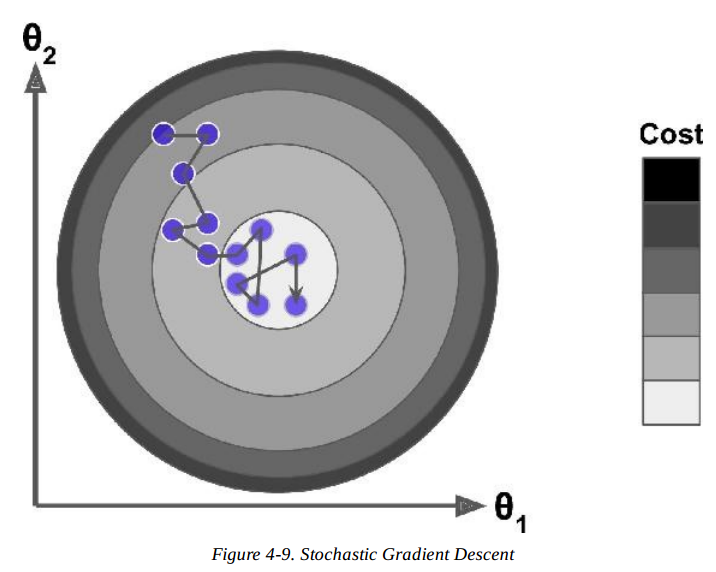

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so Stochastic Gradient Descent **has a better chance of finding the global minimum** than Batch Gradient Descent does.

Therefore randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. 

One solution to this dilemma is to gradually *reduce the learning rate*. 

The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. 

This process is called **simulated annealing**, because it resembles the process of annealing in metallurgy where molten metal is slowly cooled down. 

The function that determines the learning rate at each iteration is called the **learning
schedule**. 

If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. 

If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.


This code implements Stochastic Gradient Descent using a simple learning schedule:

In [53]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters


def learning_schedule(t):
    return t0 / (t + t1)


theta = np.random.randn(2, 1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        #         print(eta)
        theta = theta - eta * gradients

By convention we iterate by rounds of *m* iterations; each round is called an **epoch**. While the Batch Gradient Descent code iterated 1,000 times through the whole training set, this code goes through the training set only 50 times and reaches a fairly good solution:

In [54]:
theta

array([[4.09213254],
       [2.82523568]])

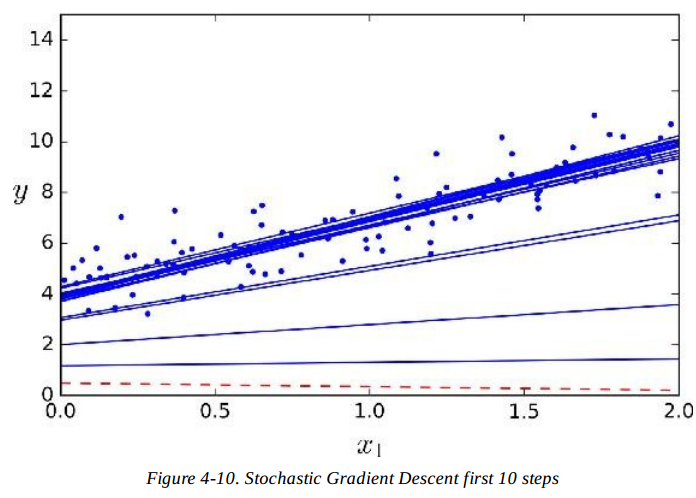

Note that since instances are picked randomly, some instances may be **picked several times per epoch** while others may not be picked at all. 

If you want to be sure that the algorithm goes through **every instance** at each epoch, another approach is to **shuffle the training set, then go through it instance by instance**, then shuffle it again, and so on. However, this generally converges more slowly.

To perform Linear Regression using SGD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function. 

The following code runs 50 epochs, starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one), and it does not use any regularization (`penalty=None`;):

In [55]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=50,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [56]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.13236429]), array([2.8197814]))

#### Mini-batch Gradient Descent

At each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on **small random sets of instances called minibatches**. 

The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with SGD, especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression as we saw earlier). 

Figure 4-11 shows the paths taken by the three Gradient Descent algorithms in parameter space during training. They all end up near the minimum, but Batch GD’s path actually stops at the minimum, while both Stochastic GD and Minibatch GD continue to walk around. 

Don’t forget that Batch GD takes a lot of time to take each step, and Stochastic GD and Mini-batch GD would also reach the minimum if you used a good learning schedule.

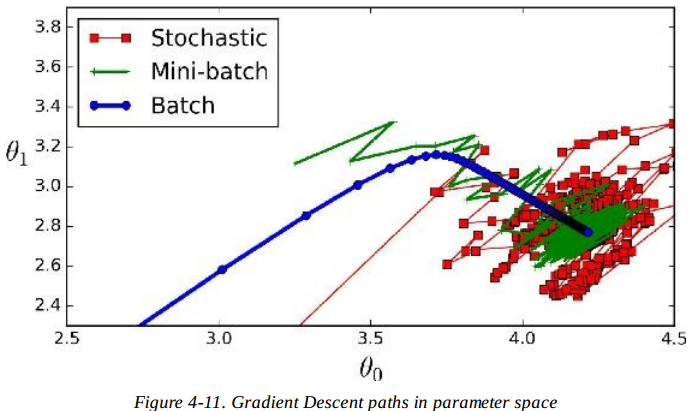

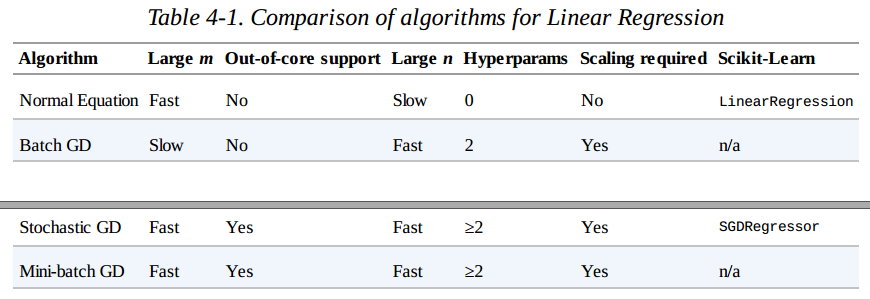

There is almost no difference after training: all these algorithms end up with very similar models and make predictions in exactly
the same way.

### Polynomial Regression

What if your data is actually more complex than a simple straight line? 

You can actually use a linear model to fit nonlinear data. A simple way to do this is to **add powers of each feature as new features, then train a linear model on this extended set of features**. 
This technique is called Polynomial Regression.

Let’s generate some nonlinear data, based on a simple quadratic equation:

In [57]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

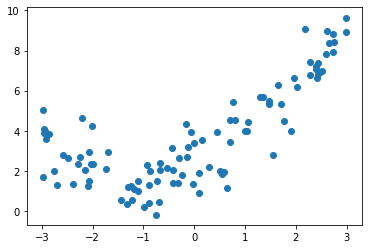

In [58]:
plt.scatter(X, y)

Let’s use Scikit-Learn’s `PolynomialFeatures` class to transform our training data, adding the square (2nd-degree polynomial) of each feature in the training set as new features (in this case there is just one feature):

In [59]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [60]:
X_poly = poly_features.fit_transform(X)

In [61]:
X[0]

array([0.50397147])

In [62]:
X_poly[0]

array([0.50397147, 0.25398724])

`X_poly` now contains the original feature of `X` plus the square of this feature. Now you can fit a `LinearRegression` model to this extended training data:

In [63]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
lin_reg.intercept_, lin_reg.coef_

(array([2.27219638]), array([[1.01067744, 0.46350059]]))

In [65]:
x_test = PolynomialFeatures(degree=2, include_bias=False).fit_transform(
    np.arange(-3, 3, 0.1).reshape(-1, 1)
)

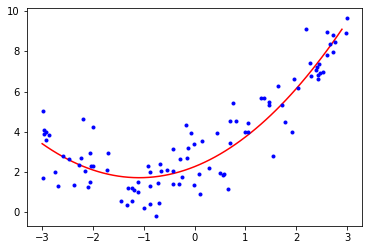

In [66]:
plt.plot(np.arange(-3, 3, 0.1).reshape(-1, 1), lin_reg.predict(x_test), "r-")
# plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.show()

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). 

This is made possible by the fact that `PolynomialFeatures` also adds all combinations of features up to the given degree. 

For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features a2, a3, b2, and b3, but also the combinations $ab, a^2b$, and $ab^2$.

WARNING

`PolynomialFeatures(degree=d)` transforms an array containing $n$ features into an array containing ($\frac{(n+d)!}{n! d!}$) features.

## Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression.  

Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

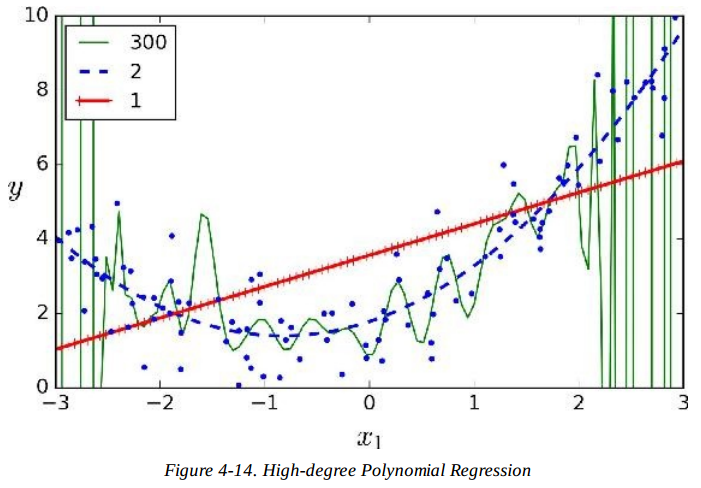

high-degree Polynomial Regression model is severely overfitting the training data

the linear model is underfitting it. 

The model that will generalize best in this case is the quadratic model.

In general you won’t know what function generated the data, so how can you decide how complex your model should be? 

How can you tell that your model is overfitting or underfitting the data?

In Chapter 2 you used *cross-validation* to get an estimate of a model’s generalization performance. 

If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. 

If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way is to look at the **learning curves**: these are plots of the model’s performance on the training set and the validation set as a function of the **training set size**. 

To generate the plots, simply train the model several times on **different sized subsets** of the training set. The following code defines a function that plots the learning curves of a model given some training data:

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

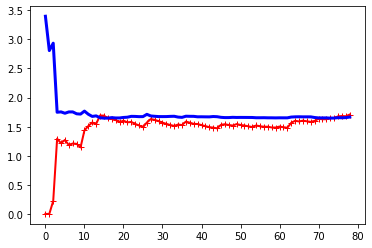

In [68]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

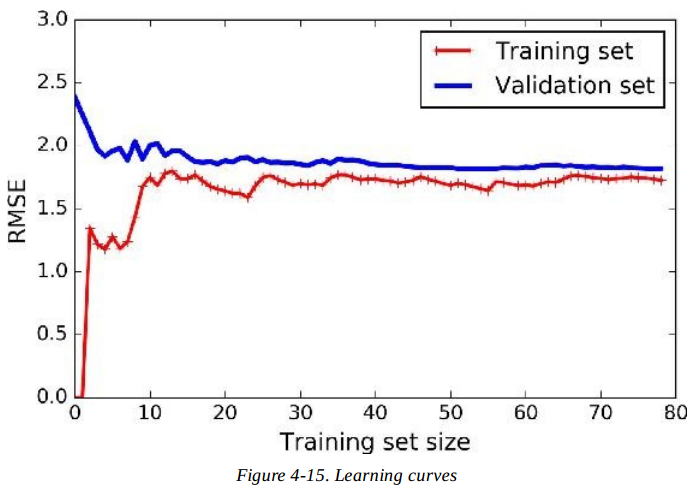

First, let’s look at the performance on the training data: 

* When there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. 

* As new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point *adding new instances to the training set doesn’t make the average error much better or worse*. 

Let’s look at the performance of the model on the validation data:

* When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. 
* Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of an underfitting model. Both curves have **reached a plateau**; they are **close** and **fairly high**.

**TIP**
If your model is underfitting the training data, adding more training examples will not help. You need to use a **more complex model** or come up with **better features**.

Look at the learning curves of a 10th-degree polynomial model on the same data:

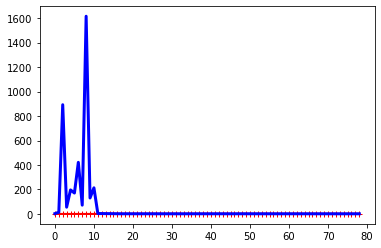

In [69]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline(
    (
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    )
)
plot_learning_curves(polynomial_regression, X, y)

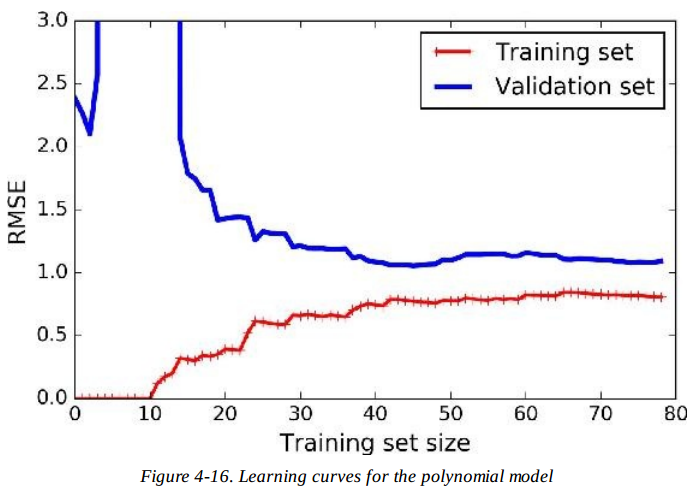

**TIP**

**One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.**

##### THE BIAS/VARIANCE TRADEOFF

A model’s generalization error can be expressed as the sum of three very different errors:
    
**Bias**

This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

**Variance**

This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

**Irreducible error**

This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically **increase its variance and reduce its bias**. 

Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model: 

the fewer degrees of freedom it has, the harder it will be for it to overfit the data. 

For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by **constraining the weights** of the model:

Ridge Regression, Lasso Regression, and Elastic Net

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to $\alpha\sum^n{\theta_{i}^2}$ is added to the cost function. 

This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. 

**Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure.**

It is quite common for the cost function used during training to be different from the performance measure used for testing. Apart from regularization, another reason why they might be different is that a **good training cost function** should have optimization-friendly  derivatives, while the performance measure us d for testing should be as close as possible to the final objective. A good example of this is a classifier trained using a cost function such as the log loss (discussed in a moment) but evaluated using precision/recall.

The hyperparameter α controls how much you want to regularize the model. 

If α = 0 then Ridge Regression is just Linear Regression. 

If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. 

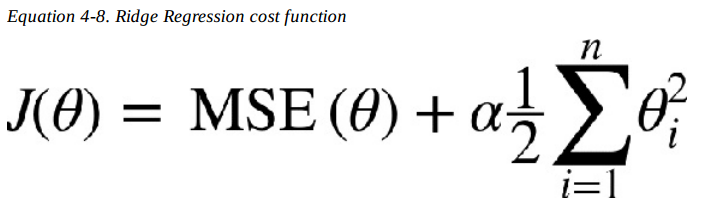

Note that the bias term $\theta_0$ is not regularized (the sum starts at i = 1, not 0). 

If we define $W$ as the vector of feature weights ($\theta_1$ to $\theta_n$), then the  regularization term is simply equal to $1/2(W_2)^2$, where · 2
represents the $l_2$ norm of the weight vector. 

For Gradient Descent, just add $\alpha W$ to the MSE gradient vector 

**It is important to scale the data (e.g., using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.**

Figure 4-17 shows several Ridge models trained on some linear data using different α value. 

On the left, plain Ridge models are used, leading to linear predictions. 

On the right, the data is first expanded using `PolynomialFeatures(degree=10)`, then it is scaled using a `StandardScaler`, and finally the `Ridge` models are applied to the resulting features: this is Polynomial Regression with Ridge regularization.

Note how increasing α leads to flatter (i.e., less extreme, more reasonable) predictions; this reduces the model’s variance but increases its bias.

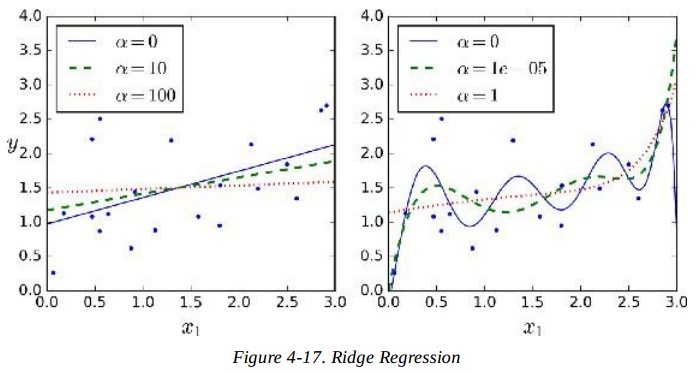

As with Linear Regression, we can perform Ridge Regression either by computing a **closed-form** equation or by performing **Gradient Descent**. The pros and cons are the same. 

Equation 4-9 shows the closed-form solution (where $A$ is the $n × n$ identity matrix except with a 0 in the top-left cell, corresponding to the bias term)

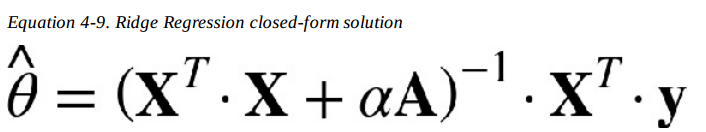

Here is how to perform Ridge Regression with Scikit-Learn using a closed-form solution (a variant of Equation 4-9 using a matrix factorization technique by André-Louis Cholesky):

In [70]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.24867301]])

And using Stochastic Gradient Descent:

In [71]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.23568796])

The `penalty` hyperparameter sets the type of regularization term to use. Specifying "l2" indicates that you want SGD to add a regularization term to the cost function equal to half the square of the $l_2$ norm of the weight vector: this is simply Ridge Regression.

### Lasso Regression

Least Absolute Shrinkage and Selection Operator Regression (simply called Lasso Regression) is
another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but **it uses the $l_1$ norm of the weight vector instead of half the square of the $l_2$ norm**

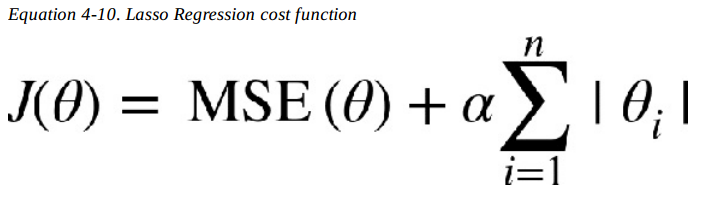

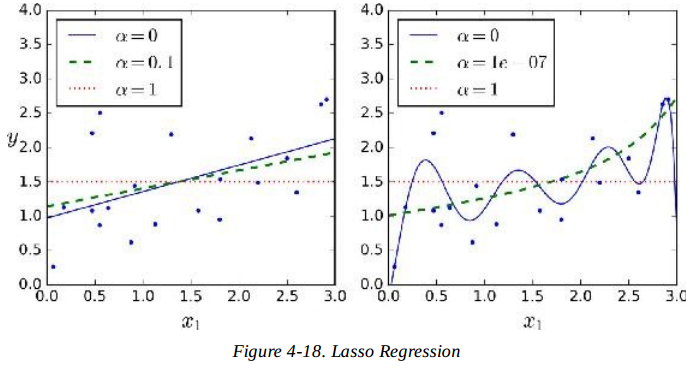

An important characteristic of Lasso Regression: 

It tends to completely eliminate the weights of the least important features (i.e., set them to zero).

For example, the dashed line in the right plot on Figure 4-18 (with α = 10-7) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. 

In other words, **Lasso Regression automatically performs feature selection and outputs a
sparse model** (i.e., with few nonzero feature weights).

You can get a sense of why this is the case by looking at Figure 4-19: 

on the top-left plot: 

the background contours (ellipses) represent an **unregularized MSE** cost function (α = 0)

the white circles show the Batch Gradient Descent path with that cost function. 


The foreground contours (diamonds) represent the ℓ1 penalty, and the triangles show the BGD path for this penalty only (α → ∞). Notice how the path first reaches $\theta_1 = 0$, then rolls down a gutter until it reaches $\theta_2 = 0$. 

On the top-right plot, the contours represent the same cost function plus an ℓ1 penalty with α = 0.5. The global minimum is on the $\theta_2 = 0$ axis. BGD first reaches $\theta_2 = 0$, then rolls down the gutter until it reaches the global minimum. 

The two bottom plots show the same thing but uses an ℓ2 penalty instead. The regularized minimum is closer to θ = 0 than the unregularized minimum, but the weights do not get fully eliminated.

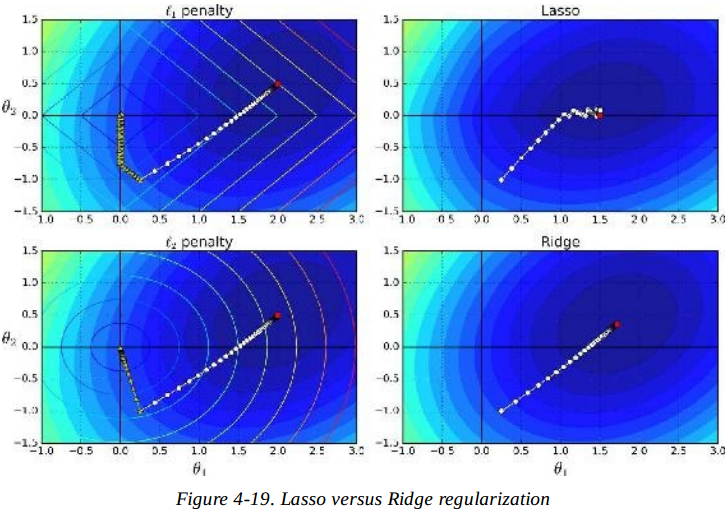

TIP

On the Lasso cost function, the BGD path tends to bounce across the gutter toward the end. This is because the slope changes abruptly at θ2 = 0. You need to gradually reduce the learning rate in order to actually converge to the global minimum

The Lasso cost function is not differentiable at θi = 0 (for i = 1, 2, , n), but Gradient Descent still works fine if you use a **subgradient vector** g instead when any θi = 0. Equation 4-11 shows a subgradient vector equation you can use for Gradient Descent with the Lasso cost function.

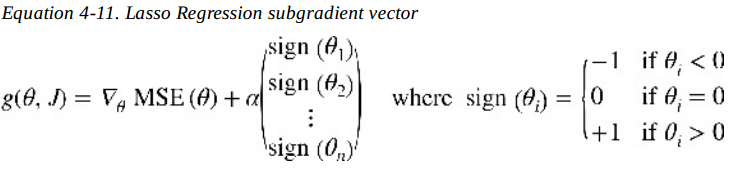

Here is a small Scikit-Learn example using the `Lasso` class. Note that you could instead use an `SGDRegressor(penalty="l1")`:

In [72]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.20488513])

### Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. 

The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression.

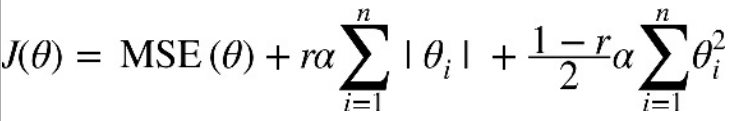

Plain Linear Regression (i.e., without any regularization), Ridge, Lasso, or Elastic Net?

Generally you should avoid plain Linear Regression.

Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features’ weights down to zero as we have discussed. 

In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here is a short example using Scikit-Learn’s ElasticNet (`l1_ratio` corresponds to the mix ratio r)

In [73]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.20570741])

## Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent:

stop training as soon as the **validation error reaches a minimum**. This is called **early stopping**. 

As the epochs go by, the algorithm learns and its prediction error (RMSE) on the
training set naturally goes down, and so does its prediction error on the validation set. 

However, after a while the validation error stops decreasing and actually starts to go back up. 

This indicates that the model has started to overfit the training data.

With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch.”

**TIP**

With Stochastic and Mini-batch Gradient Descent, the curves are **not so smooth**, and it may be hard to know whether you have reached the minimum or not. 

One solution is to **stop only after the validation error has been above the minimum** for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

Here is a basic implementation of early stopping:

In [74]:
from sklearn.base import clone

sgd_reg = SGDRegressor(
    n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005
)
minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

TypeError: __init__() got an unexpected keyword argument 'n_iter'

Note that with `warm_start=True`, when the `fit()` method is called, it just continues training where it left off instead of restarting from scratch.

## Logistic Regression

Some regression algorithms can be used for classification as well (and vice versa). 

Logistic Regression (also called Logit Regression) is commonly used to estimate **the probability that an instance belongs to a particular class** (e.g., what is the probability that this email is spam?). 

If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). 

This makes it a binary classifier.

### Estimating Probabilities

Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the **logistic** of this result.

The logistic — also called the **logit**, noted σ(·) — is a sigmoid function (i.e., S-shaped) that outputs a
number between 0 and 1.

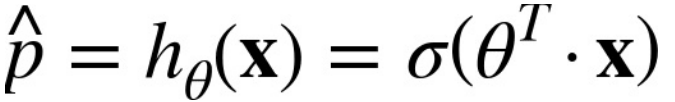

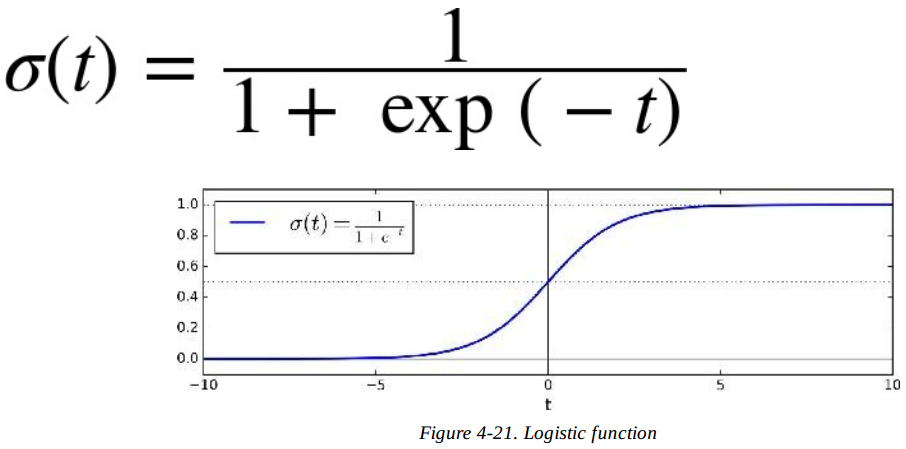

Once the Logistic Regression model has estimated the probability $\hat p= hθ(x)$ that an instance x belongs to the positive class, it can make its prediction ŷ easily 

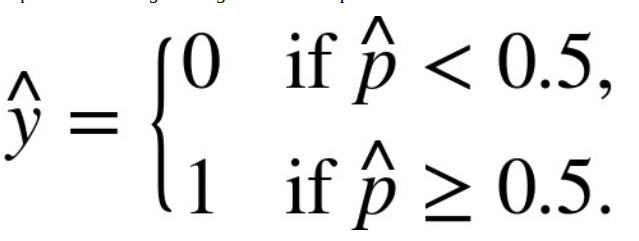

Notice that σ(t) < 0.5 when t < 0, and σ(t) ≥ 0.5 when t ≥ 0, so a Logistic Regression model predicts 1 if θT · x is positive, and 0 if it is negative.

#### Training and Cost Function

The objective of training is to set the parameter vector θ so that the model estimates
high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0). 
This idea is captured by the cost function shown in Equation 4-16 for a single training instance x.

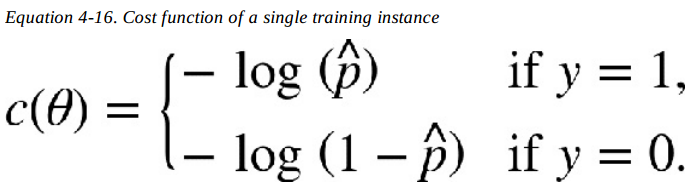

This cost function makes sense because – log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance. 

On the other hand, – log(t) is close to 0 when t is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is simply the average cost over all training instances. It can be written in a single expression (as you can verify easily), called the **log loss**:

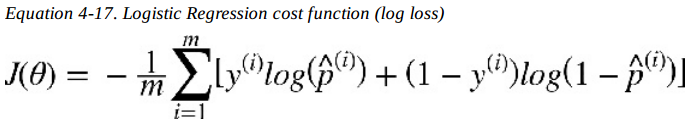

The bad news: 

There is no known closed-form equation to compute the value of θ that minimizes this cost function (there is no equivalent of the Normal Equation). 

The good news: 

Cost function is **convex**, so Gradient Descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough). 

The partial derivatives of the cost function with regards to the $j^{th}$ model parameter $θ_j$ is given by:

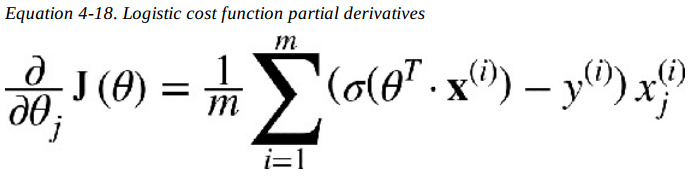

This equation looks very much like Equation 4-5: for each instance it computes the prediction error and multiplies it by the $j^{th}$ feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives you can use it in the Batch Gradient Descent algorithm. 

For Stochastic GD you would of course just take one instance at a time, and for Mini-batch GD you would use a mini-batch at a time.

### Decision Boundaries

Let’s use the iris dataset to illustrate Logistic Regression. 

Let’s try to build a classifier to detect the Iris-Virginica type based only on the petal width feature. First let’s load the data:

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

In [ ]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 to 3 cm

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")

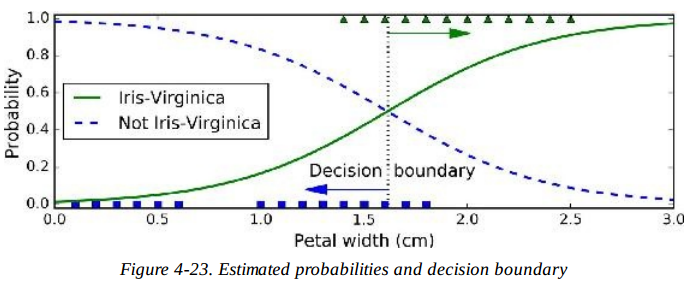

The petal width of Iris-Virginica flowers (represented by triangles) ranges from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of overlap.

Above about 2 cm the classifier is highly confident that the flower is an Iris-Virginica (it outputs a high probability to that class), while below 1 cm it is highly confident that it is not an Iris-Virginica (high probability for the “Not Iris-Virginica” class). 

In between these extremes, the classifier is unsure. However, if you ask it to predict the class (using the `predict()` method rather than the `predict_proba()` method), it will return whichever class is the most likely.

Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is higher than 1.6 cm, the classifier will predict that the flower is an Iris-Virginica, or else it will predict that it is not (even if it is not very confident):

In [ ]:
log_reg.predict([[1.7], [1.5]])

Figure 4-24 shows the same dataset but this time displaying two features: petal width and length. Once trained, the Logistic Regression classifier can estimate the probability that a new flower is an IrisVirginica based on these two features. 

The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary. Note that it is a linear boundary. 

Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). 

All the flowers beyond the top-right line have an over 90% chance of being Iris-Virginica according to the model.

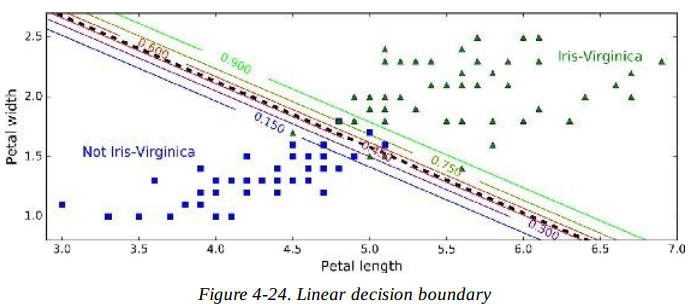

Just like the other linear models, Logistic Regression models can be regularized using ℓ1 or ℓ2 penalties.
Scitkit-Learn actually adds an ℓ2 penalty by default.

*NOTE*
The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression modelis not **alpha** (as in other linear models), but its inverse: **C**. 

**The higher the value of C, the less the model is regularized.**

### Softmax Regression

The Logistic Regression model can be generalized to **support multiple classes** directly, without having to train and combine multiple binary classifiers (as discussed in Chapter 3). This is called **Softmax Regression, or Multinomial Logistic Regression**.

The idea is quite simple: when given an instance x, the Softmax Regression model first computes a score $s_k(x)$ **for each class k**, then estimates the probability of each class by applying the softmax function (also called **the normalized exponential**) to the scores. The equation to compute $s_k(x)$ should look familiar, as it is just like the equation for Linear Regression prediction.

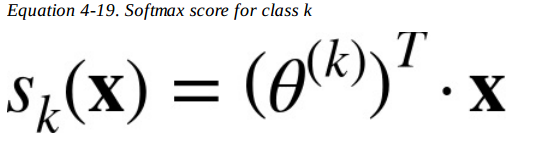

Note that each class has its own dedicated parameter vector θ(k). 

All these vectors are typically stored as rows in a **parameter matrix Θ**.

Once you have computed the score of every class for the instance x, you can estimate the probability k that the instance belongs to class k by running the scores through the softmax function (Equation 4-20): it computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials).

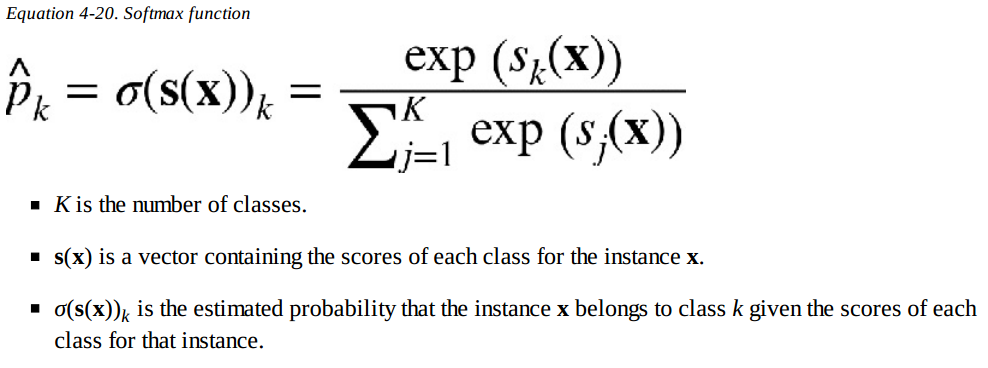

Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the **highest estimated probability** (which is simply the class with the highest score), as shown in:

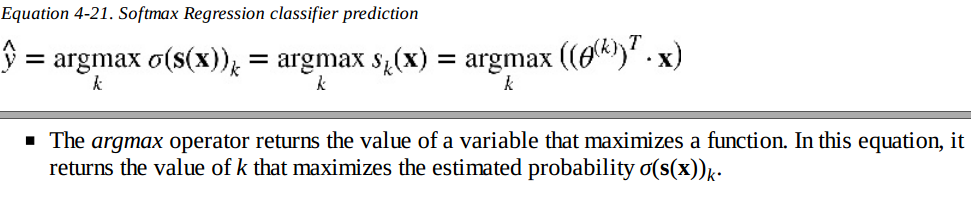

TIP

The Softmax Regression classifier predicts **only one class at a time** (i.e., **it is multiclass**, not multioutput) so it should be used only with mutually exclusive classes such as different types of plants. You cannot use it to recognize multiple people in one picture.

Let’s take a look at training. 
The objective is to **have a model that estimates a high probability for the target class (and consequently a low probability for the other classes)**. Minimizing the cost function shown in Equation 4-22, **called the cross entropy**, should lead to this objective because **it penalizes the model when it estimates a low probability for a target class.**

Cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes.

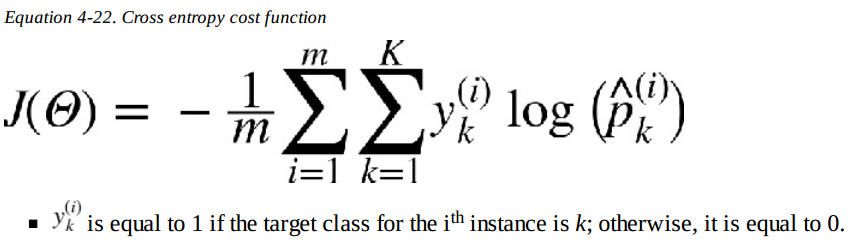

**Notice that when there are just two classes (K = 2), this cost function is equivalent to the Logistic Regression’s cost function (*log loss*)**

**CROSS ENTROPY**

Cross entropy originated from information theory. 

Suppose you want to efficiently transmit information about the weather every day. If there are eight options (sunny, rainy, etc.), you could encode each option using 3 bits since 2^3 = 8.

However, if you think it will be sunny almost every day, it would be much more efficient to code “sunny” on just one bit (0) and the other seven options on 4 bits (starting with
a 1). Cross entropy measures the average number of bits you actually send per option. If your assumption about the weather is perfect,
cross entropy will just be equal to the entropy of the weather itself (i.e., its intrinsic unpredictability). But if your assumptions are wrong
(e.g., if it rains often), cross entropy will be greater by an amount called the Kullback–Leibler divergence.

The cross entropy between two probability distributions p and q is defined as (at least
when the distributions are discrete).

The gradient vector of this cost function with regards to $\theta^{(k)}$ is given by 

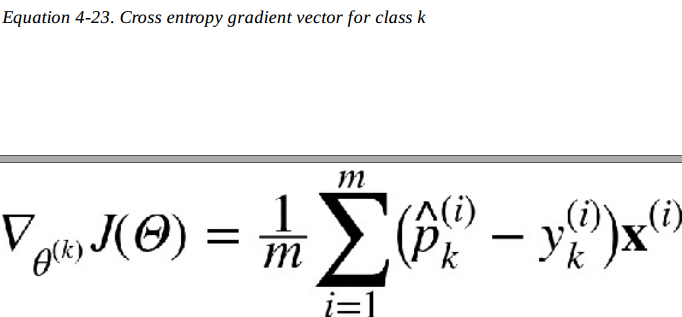

Now you can compute the gradient vector for every class, then use Gradient Descent (or any other optimization algorithm) to find the parameter matrix Θ that minimizes the cost function.

Let’s use Softmax Regression to classify the iris flowers into all three classes. 

Scikit-Learn’s `LogisticRegression` uses **one-versus-all** by default when you train it on more than two classes, but you can set the `multi_class` hyperparameter to "multinomial" to switch it to Softmax Regression instead.

You must also specify a `solver` that supports Softmax Regression, such as the **"lbfgs"** solver. 

It also applies ℓ2 regularization by default, which you can control using the hyperparameter `C`.

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

So the next time you find an iris with 5 cm long and 2 cm wide petals, you can ask your model to tell you what type of iris it is, and it will answer Iris-Virginica (class 2) with 94.2% probability (or IrisVersicolor with 5.8% probability):

In [ ]:
softmax_reg.predict([[5, 2]])

In [ ]:
softmax_reg.predict_proba([[3, 2.8]])

Figure 4-25 shows the resulting decision boundaries, represented by the background colors.

Notice that the decision boundaries between any two classes are linear. The figure also shows the probabilities for the Iris-Versicolor class, represented by the curved lines (e.g., the line labeled with 0.450 represents the 45% probability boundary).

Notice that the model can predict a class that has an estimated probability below 50%. For example, at the point where all decision boundaries meet, all classes have an equal estimated probability of 33%.

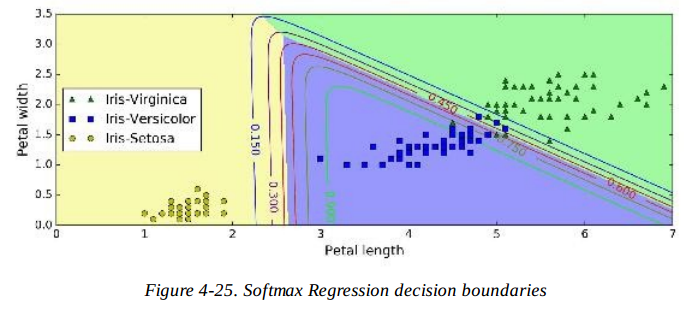